# ドル円レート 日足 メジアン統計

In [1]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pingouin as pg
import seaborn as sns
import yfinance as yf

In [2]:
code = 'USDJPY=X'
symbol = code
ticker = yf.Ticker(symbol)

In [3]:
# 週足で過去 5 年分のデータを取得
df0 = ticker.history(period='5y', interval='1d')

# ローソク足のチャートには、そのうち過去 3 年分のみ使用する
dt_last = df0.index[len(df0) - 1]
tdelta_1y =  datetime.timedelta(days=366)
df = df0[df0.index >= dt_last - tdelta_1y]
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-09-11 00:00:00+01:00,142.233994,142.468002,140.718002,142.233994,0,0.0,0.0
2024-09-12 00:00:00+01:00,142.589996,143.011002,141.912994,142.589996,0,0.0,0.0
2024-09-13 00:00:00+01:00,141.498993,141.526993,140.362000,141.498993,0,0.0,0.0
2024-09-16 00:00:00+01:00,140.789993,140.899002,139.578003,140.789993,0,0.0,0.0
2024-09-17 00:00:00+01:00,140.789993,141.850006,140.322998,140.789993,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-09-08 00:00:00+01:00,148.343994,148.546005,147.470993,148.343994,0,0.0,0.0
2025-09-09 00:00:00+01:00,147.363998,147.414993,146.326996,147.363998,0,0.0,0.0
2025-09-10 00:00:00+01:00,147.391998,147.595993,147.128006,147.391998,0,0.0,0.0


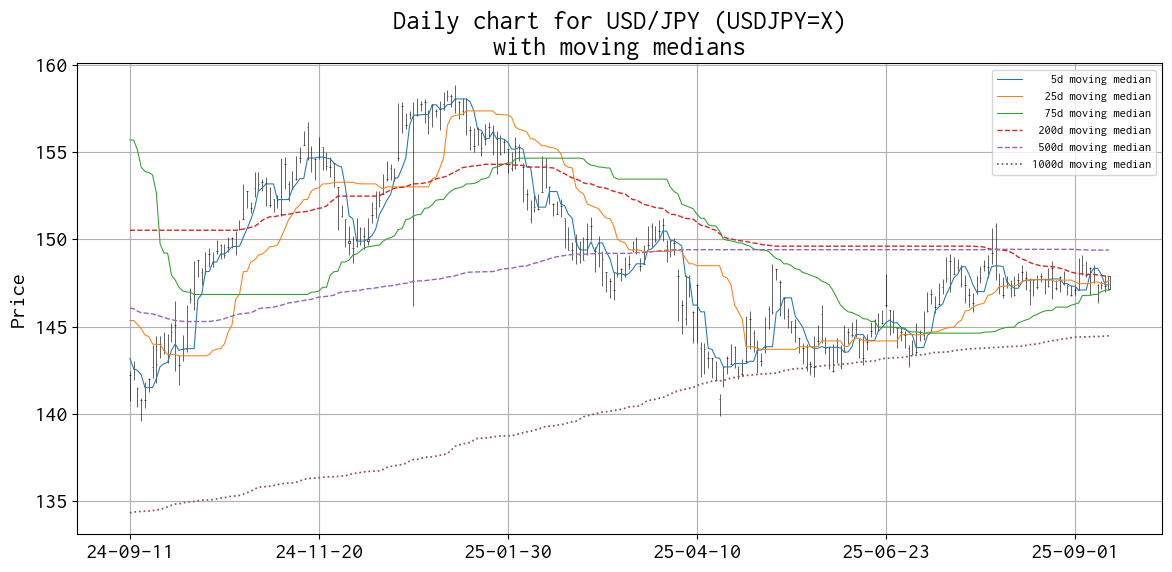

In [4]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

mm05 = df0['Close'].rolling(5).median()
mm25 = df0['Close'].rolling(25).median()
mm75 = df0['Close'].rolling(75).median()
mm200 = df0['Close'].rolling(200).median()
mm500 = df0['Close'].rolling(500).median()
mm1000 = df0['Close'].rolling(1000).median()
apds  = [
    mpf.make_addplot(mm05[df.index], width=0.75, label='   5d moving median', ax=ax),
    mpf.make_addplot(mm25[df.index], width=0.75, label='  25d moving median', ax=ax),
    mpf.make_addplot(mm75[df.index], width=0.75, label='  75d moving median', ax=ax),
    mpf.make_addplot(mm200[df.index], width=1.00, linestyle='dashed', label=' 200d moving median', ax=ax),
    mpf.make_addplot(mm500[df.index], width=1.00, linestyle='dashed', label=' 500d moving median', ax=ax),
    mpf.make_addplot(mm1000[df.index], width=1.25, linestyle='dotted', label='1000d moving median', ax=ax),
]   

mpf.plot(
    df, type='candle', style='default',
    volume=False,
    datetime_format='%y-%m-%d',
    addplot=apds,
    xrotation=0,
    ax=ax,
)
ax.set_title('Daily chart for %s (%s)\nwith moving medians' % (ticker.info['longName'], symbol))

ax.legend(loc='best', fontsize=9)
ax.grid()

plt.tight_layout()
plt.savefig('report_daily_chart_robust_%s.png' % code)
plt.show()

In [5]:
df.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-09-12 00:00:00+01:00,147.153,147.904007,147.110001,147.878006,0,0.0,0.0


In [6]:
df.tail(2)['Close']

Date
2025-09-11 00:00:00+01:00    147.332001
2025-09-12 00:00:00+01:00    147.878006
Name: Close, dtype: float64

In [7]:
df.tail(2)['Close'].diff()

Date
2025-09-11 00:00:00+01:00         NaN
2025-09-12 00:00:00+01:00    0.546005
Name: Close, dtype: float64

## Robust Bollinger bands

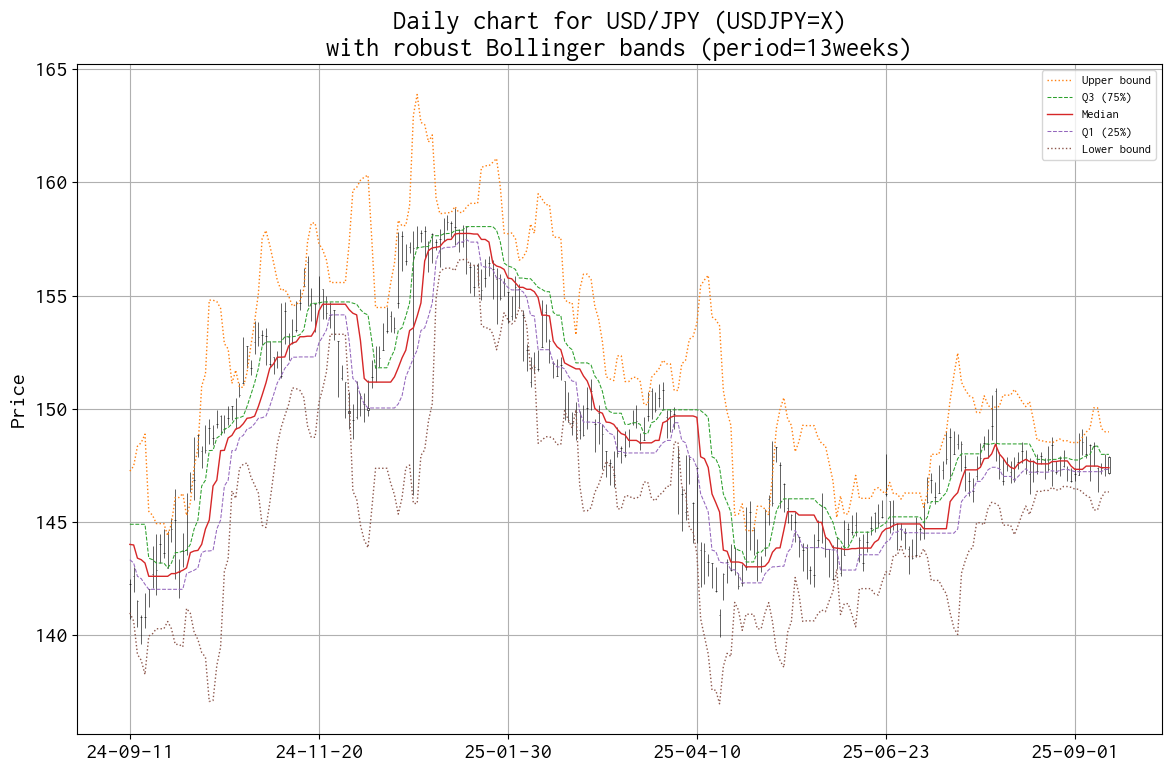

In [10]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(12, 8))

# Bollinger bands
period = 13
mv_median = df0['Close'].rolling(period).median()
mv_q1 = df0['Close'].rolling(period).quantile(.25)
mv_q3 = df0['Close'].rolling(period).quantile(.75)
mv_iqr = mv_q3 - mv_q1
mv_lower = mv_q1 - mv_iqr * 1.5
mv_upper = mv_q3 + mv_iqr * 1.5

apds  = [
    mpf.make_addplot(mv_upper[df.index], width=1, color='C1', linestyle='dotted', label='Upper bound', ax=ax),
    mpf.make_addplot(mv_q3[df.index], width=0.75, color='C2', linestyle='dashed', label='Q3 (75%)', ax=ax),
    mpf.make_addplot(mv_median[df.index], width=1, color='C3', label='Median', ax=ax),
    mpf.make_addplot(mv_q1[df.index], width=0.75, color='C4', linestyle='dashed', label='Q1 (25%)', ax=ax),
    mpf.make_addplot(mv_lower[df.index], width=1, color='C5', linestyle='dotted', label='Lower bound', ax=ax),
]

mpf.plot(df, type='candle', style='default', addplot=apds, datetime_format='%y-%m-%d', xrotation=0, ax=ax)

ax.grid()
ax.legend(loc='best', fontsize=9)

try:
    ax.set_title('Daily chart for %s (%s)\nwith robust Bollinger bands (period=%dweeks)' % (ticker.info['longName'], symbol, period))
except KeyError:
    ax.set_title('Daily chart for %s\nwith robust Bollinger bands (period=%sweeks)' % (symbol, period))

plt.tight_layout()
plt.savefig('report_daily_chart_bollinger_robust_%s.png' % code)
plt.show()

## ヒストグラム

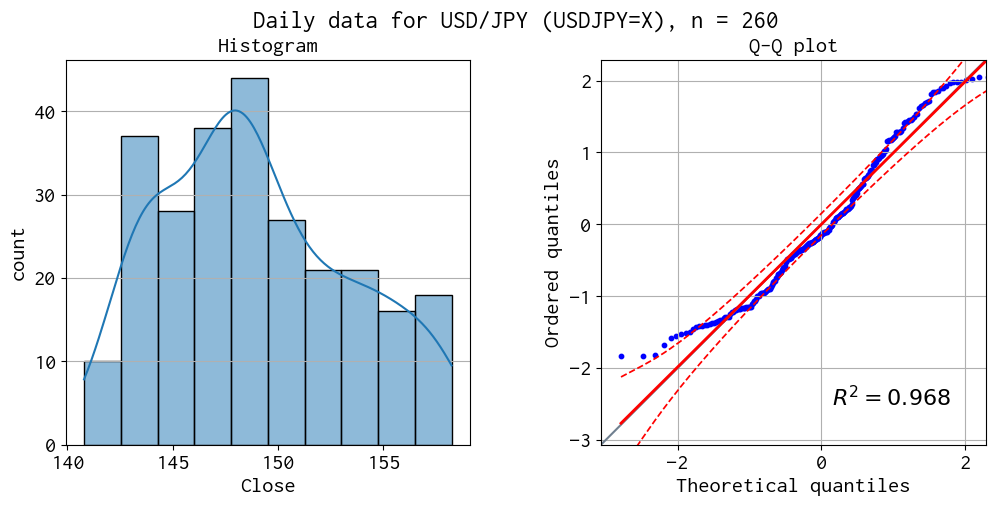

In [9]:
plt.rcParams['font.size'] = 16

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(
    df['Close'],
    kde=True,
    ax=axes[0]
)

# ヒストグラム
axes[0].set_xlabel("Close")
axes[0].set_ylabel("count")
axes[0].grid(axis = 'y')
axes[0].set_title('Histogram', fontsize=16)

# Q-Q プロット
pg.qqplot(df['Close'], s=10,  ax=axes[1])
axes[1].set_title('Q-Q plot', fontsize=16)
axes[1].grid()

plt.suptitle('Daily data for %s (%s), n = %d' % (ticker.info['longName'], symbol, len(df)), fontsize=18)
plt.subplots_adjust(wspace=0.3)
plt.savefig('report_daily_histogram_qqplot_%s.png' % code)
plt.show()